In [4]:
import sys

In [5]:
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install gym==0.23.1
!{sys.executable} -m pip install pygame

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import numpy as np
import gym
import random
import time
from IPython.display import clear_output
from IPython.display import display
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv
import ipywidgets as widgets


In [38]:
from contextlib import closing
from io import StringIO
from os import path
from typing import Optional
import pygame
from pygame.constants import SRCALPHA
import numpy as np

from gym import Env, spaces, utils
from gym.envs.toy_text.utils import categorical_sample

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": ["SFFF", "FHFH", "FFFH", "HFFG"],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG",
    ],
}


def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == "G":
                        return True
                    if res[r_new][c_new] != "H":
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(["F", "H"], (size, size), p=[p, 1 - p])
        res[0][0] = "S"
        res[-1][-1] = "G"
        valid = is_valid(res)
    return ["".join(x) for x in res]


class CustomFrozenLakeEnv(Env):
    """
    Frozen lake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H) by walking over
    the Frozen(F) lake. The agent may not always move in the intended direction due to the slippery nature of the frozen lake.


    ### Action Space
    The agent takes a 1-element vector for actions.
    The action space is `(dir)`, where `dir` decides direction to move in which can be:

    - 0: LEFT
    - 1: DOWN
    - 2: RIGHT
    - 3: UP

    ### Observation Space
    The observation is a value representing the agent's current position as
    current_row * nrows + current_col (where both the row and col start at 0).
    For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15.
    The number of possible observations is dependent on the size of the map.
    For example, the 4x4 map has 16 possible observations.

    ### Rewards

    Reward schedule:
    - Reach goal(G): +1
    - Reach hole(H): 0
    - Reach frozen(F): 0

    ### Arguments

    ```
    gym.make('FrozenLake-v1', desc=None,map_name="4x4", is_slippery=True)
    ```

    `desc`: Used to specify custom map for frozen lake. For example,

        desc=["SFFF", "FHFH", "FFFH", "HFFG"].

    `map_name`: ID to use any of the preloaded maps.

        "4x4":[
            "SFFF",
            "FHFH",
            "FFFH",
            "HFFG"
            ]

        "8x8": [
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG",
        ]

    `is_slippery`: True/False. If True will move in intended direction with
    probability of 1/3 else will move in either perpendicular direction with
    equal probability of 1/3 in both directions.

        For example, if action is left and is_slippery is True, then:
        - P(move left)=1/3
        - P(move up)=1/3
        - P(move down)=1/3

    ### Version History
    * v1: Bug fixes to rewards
    * v0: Initial versions release (1.0.0)
    """

    metadata = {"render_modes": [
        "human", "ansi", "rgb_array"], "render_fps": 4}

    def __init__(self, desc=None, map_name="4x4", is_slippery=True):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        self.initial_state_distrib = np.array(
            desc == b"S").astype("float64").ravel()
        self.initial_state_distrib /= self.initial_state_distrib.sum()

        self.P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row * ncol + col

        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        def update_probability_matrix(row, col, action):
            newrow, newcol = inc(row, col, action)
            newstate = to_s(newrow, newcol)
            newletter = desc[newrow, newcol]
            done = bytes(newletter) in b"GH"
            match newletter:
                case b"G":
                    reward = float(1)
                case b"H":
                    reward = float(-1)
                case b"F":
                    reward = float(0.0)
                case b"S":
                    reward = float(0.0)
            return newstate, reward, done

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = self.P[s][a]
                    letter = desc[row, col]
                    if letter in b"GH":
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                li.append(
                                    (1.0 / 3.0, *update_probability_matrix(row, col, b))
                                )
                        else:
                            li.append(
                                (1.0, *update_probability_matrix(row, col, a)))

        self.observation_space = spaces.Discrete(nS)
        self.action_space = spaces.Discrete(nA)

        # pygame utils
        self.window_size = (min(64 * ncol, 512), min(64 * nrow, 512))
        self.window_surface = None
        self.clock = None
        self.hole_img = None
        self.cracked_hole_img = None
        self.ice_img = None
        self.elf_images = None
        self.goal_img = None
        self.start_img = None

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, d = transitions[i]
        self.s = s
        self.lastaction = a
        return (int(s), r, d, {"prob": p})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        return_info: bool = False,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None

        if not return_info:
            return int(self.s)
        else:
            return int(self.s), {"prob": 1}

    def render(self, mode="human"):
        desc = self.desc.tolist()
        if mode == "ansi":
            return self._render_text(desc)
        else:
            return self._render_gui(desc, mode)

    def _render_gui(self, desc, mode):
        if self.window_surface is None:
            pygame.init()
            pygame.display.init()
            pygame.display.set_caption("Frozen Lake")
            if mode == "human":
                self.window_surface = pygame.display.set_mode(self.window_size)
            else:  # rgb_array
                self.window_surface = pygame.Surface(self.window_size)
        if self.clock is None:
            self.clock = pygame.time.Clock()
        if self.hole_img is None:
            file_name = path.join(path.dirname(__file__), "img/hole.png")
            self.hole_img = pygame.image.load(file_name)
        if self.cracked_hole_img is None:
            file_name = path.join(path.dirname(__file__),
                                  "img/cracked_hole.png")
            self.cracked_hole_img = pygame.image.load(file_name)
        if self.ice_img is None:
            file_name = path.join(path.dirname(__file__), "img/ice.png")
            self.ice_img = pygame.image.load(file_name)
        if self.goal_img is None:
            file_name = path.join(path.dirname(__file__), "img/goal.png")
            self.goal_img = pygame.image.load(file_name)
        if self.start_img is None:
            file_name = path.join(path.dirname(__file__), "img/stool.png")
            self.start_img = pygame.image.load(file_name)
        if self.elf_images is None:
            elfs = [
                path.join(path.dirname(__file__), "img/elf_left.png"),
                path.join(path.dirname(__file__), "img/elf_down.png"),
                path.join(path.dirname(__file__), "img/elf_right.png"),
                path.join(path.dirname(__file__), "img/elf_up.png"),
            ]
            self.elf_images = [pygame.image.load(f_name) for f_name in elfs]

        board = pygame.Surface(self.window_size, flags=SRCALPHA)
        cell_width = self.window_size[0] // self.ncol
        cell_height = self.window_size[1] // self.nrow
        smaller_cell_scale = 0.6
        small_cell_w = smaller_cell_scale * cell_width
        small_cell_h = smaller_cell_scale * cell_height

        # prepare images
        last_action = self.lastaction if self.lastaction is not None else 1
        elf_img = self.elf_images[last_action]
        elf_scale = min(
            small_cell_w / elf_img.get_width(),
            small_cell_h / elf_img.get_height(),
        )
        elf_dims = (
            elf_img.get_width() * elf_scale,
            elf_img.get_height() * elf_scale,
        )
        elf_img = pygame.transform.scale(elf_img, elf_dims)
        hole_img = pygame.transform.scale(
            self.hole_img, (cell_width, cell_height))
        cracked_hole_img = pygame.transform.scale(
            self.cracked_hole_img, (cell_width, cell_height)
        )
        ice_img = pygame.transform.scale(
            self.ice_img, (cell_width, cell_height))
        goal_img = pygame.transform.scale(
            self.goal_img, (cell_width, cell_height))
        start_img = pygame.transform.scale(
            self.start_img, (small_cell_w, small_cell_h))

        for y in range(self.nrow):
            for x in range(self.ncol):
                rect = (x * cell_width, y * cell_height,
                        cell_width, cell_height)
                if desc[y][x] == b"H":
                    self.window_surface.blit(hole_img, (rect[0], rect[1]))
                elif desc[y][x] == b"G":
                    self.window_surface.blit(ice_img, (rect[0], rect[1]))
                    goal_rect = self._center_small_rect(
                        rect, goal_img.get_size())
                    self.window_surface.blit(goal_img, goal_rect)
                elif desc[y][x] == b"S":
                    self.window_surface.blit(ice_img, (rect[0], rect[1]))
                    stool_rect = self._center_small_rect(
                        rect, start_img.get_size())
                    self.window_surface.blit(start_img, stool_rect)
                else:
                    self.window_surface.blit(ice_img, (rect[0], rect[1]))

                pygame.draw.rect(board, (180, 200, 230), rect, 1)

        # paint the elf
        bot_row, bot_col = self.s // self.ncol, self.s % self.ncol
        cell_rect = (
            bot_col * cell_width,
            bot_row * cell_height,
            cell_width,
            cell_height,
        )
        if desc[bot_row][bot_col] == b"H":
            self.window_surface.blit(
                cracked_hole_img, (cell_rect[0], cell_rect[1]))
        else:
            elf_rect = self._center_small_rect(cell_rect, elf_img.get_size())
            self.window_surface.blit(elf_img, elf_rect)

        self.window_surface.blit(board, board.get_rect())
        if mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window_surface)), axes=(1, 0, 2)
            )

    @staticmethod
    def _center_small_rect(big_rect, small_dims):
        offset_w = (big_rect[2] - small_dims[0]) / 2
        offset_h = (big_rect[3] - small_dims[1]) / 2
        return (
            big_rect[0] + offset_w,
            big_rect[1] + offset_h,
        )

    def _render_text(self, desc):
        outfile = StringIO()

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write(
                f"  ({['Left', 'Down', 'Right', 'Up'][self.lastaction]})\n")
        else:
            outfile.write("\n")
        outfile.write("\n".join("".join(line) for line in desc) + "\n")

        with closing(outfile):
            return outfile.getvalue()


# Elf and stool from https://franuka.itch.io/rpg-snow-tileset
# All other assets by Mel Sawyer


In [25]:
def trainModel(env, num_episodes, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_factor=5, linear_exploration=False, accuracy=False):

    max_steps_per_episode = 1000

    q_table = np.zeros((env.observation_space.n, env.action_space.n))

    exploration_rate = max_exploration_rate
    exploration_decay_rate = (
        max_exploration_rate - min_exploration_rate) / num_episodes
    rewards_all_episodes = []
    # Q-Learning algorithm
    for episode in range(num_episodes):
        if accuracy:
            if np.sum(rewards_all_episodes[-accuracy:]) == accuracy:
                return(rewards_all_episodes)
            
        state = env.reset()

        done = False
        rewards_current_episode = 0

        for step in range(max_steps_per_episode):

            # Exploration / Exploitation trade-off
            exploration_rate_threshold = random.uniform(0, 1)

            if np.sum(q_table[state]) > 0 and exploration_rate_threshold > exploration_rate:
                action = np.argmax(q_table[state, :])
            else:
                action = env.action_space.sample()

            new_state, reward, done, info = env.step(action)

            q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate *
                                 np.max(q_table[new_state, :]))

            state = new_state
            rewards_current_episode += reward

            if done == True:
                break

        # Exploration rate decay
        if linear_exploration:
            exploration_rate -= exploration_decay_rate
        else:
            exploration_rate = (max_exploration_rate - min_exploration_rate) * \
                np.exp(-exploration_decay_rate *
                       exploration_decay_factor*episode)

        rewards_all_episodes.append(rewards_current_episode)
    return rewards_all_episodes


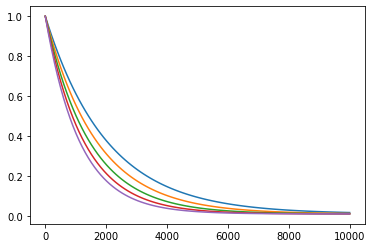

In [8]:
def explorationDecayRate(episodes,max,min,factor):
  decay_rate = (max-min)/episodes
  x = np.linspace(0,episodes,num=100)
  y = min+(max-min)*np.exp(-decay_rate*factor*x)
  plt.plot(x,y)

for i in range(5,10):
  explorationDecayRate(10000,1,0.01,i)

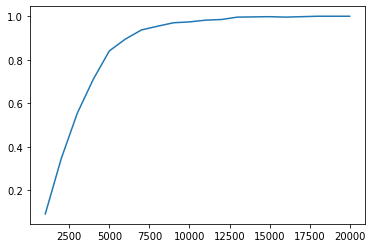

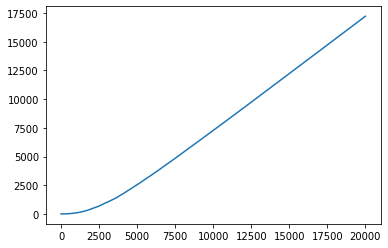

In [17]:
env = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4")
# env = CustomFrozenLakeEnv(is_slippery=False, map_name="4x4")
num_episodes = 20000
n = 1000

rewards_all_episodes = trainModel(env=env, num_episodes=num_episodes, learning_rate=0.4,
                                  discount_rate=0.9, max_exploration_rate=1, min_exploration_rate=0.01, exploration_decay_factor=8)
rewards_per_n_episodes = np.split(
    np.array(rewards_all_episodes), num_episodes / n)
cumulative_rewards = np.cumsum(rewards_all_episodes)
x = (np.arange(num_episodes / n)+1)*n
y = np.sum(rewards_per_n_episodes, 1)/n
plt.plot(x,y)
plt.show()
plt.plot(cumulative_rewards)

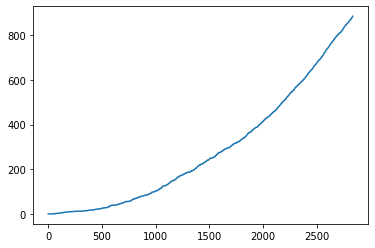

In [42]:
env = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4")
# env = CustomFrozenLakeEnv(is_slippery=False, map_name="4x4")
num_episodes = 20000
n = 1000

rewards_all_episodes = trainModel(env=env, num_episodes=num_episodes, learning_rate=0.2,
                                  discount_rate=0.99, max_exploration_rate=1, min_exploration_rate=0.01, exploration_decay_factor=8, accuracy=10)
cumulative_rewards = np.cumsum(rewards_all_episodes)
plt.plot(cumulative_rewards)

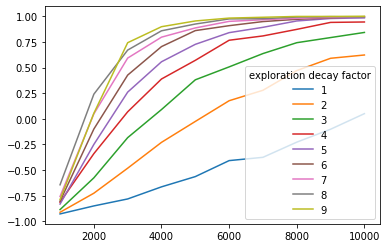

In [41]:
# env = gym.make("FrozenLake-v1", is_slippery=True, map_name="4x4")
env = CustomFrozenLakeEnv(is_slippery=False, map_name="4x4")

num_episodes = 10000
n = 1000

for i in range(1, 10):
    rewards_all_episodes = trainModel(env=env, num_episodes=num_episodes, learning_rate=0.4,
                                      discount_rate=0.9, max_exploration_rate=1, min_exploration_rate=0.01, exploration_decay_factor=i)
    rewards_per_n_episodes = np.split(
        np.array(rewards_all_episodes), num_episodes / n)
    x = (np.arange(num_episodes / n)+1)*n
    y = np.sum(rewards_per_n_episodes, 1)/n
    plt.plot(x, y, label=i)
plt.legend(title="exploration decay factor")
plt.show()


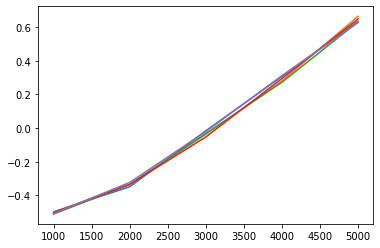

In [28]:
# env = gym.make("FrozenLake-v1", is_slippery=True, map_name="4x4")
env = CustomFrozenLakeEnv(is_slippery=False, map_name="4x4")


num_episodes = 5000
n = 1000

for i in range(5):
    rewards_all_episodes = trainModel(env=env, num_episodes=num_episodes, learning_rate=0.4,
                                      discount_rate=0.9, max_exploration_rate=1, min_exploration_rate=0.1, linear_exploration=True)
    rewards_per_n_episodes = np.split(
        np.array(rewards_all_episodes), num_episodes / n)
    x = (np.arange(num_episodes / n)+1)*n
    y = np.sum(rewards_per_n_episodes, 1)/n
    plt.plot(x, y)


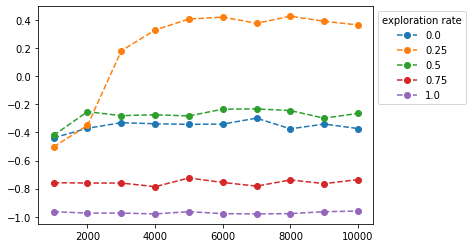

In [43]:
# env = gym.make("FrozenLake-v1", is_slippery=True, map_name="4x4")
env = CustomFrozenLakeEnv(is_slippery=False, map_name="4x4")


num_episodes = 10000
n = 1000

for i in np.linspace(0,1,num=5):
    rewards_all_episodes = trainModel(env=env, num_episodes=num_episodes, learning_rate=0.4,
                                      discount_rate=0.95, max_exploration_rate=i, min_exploration_rate=i, linear_exploration=True)
    rewards_per_n_episodes = np.split(
        np.array(rewards_all_episodes), num_episodes / n)
    x = (np.arange(num_episodes / n)+1)*n
    y = np.sum(rewards_per_n_episodes, 1)/n
    plt.plot(x, y,'o--', label=i)
    plt.legend(title="exploration rate", bbox_to_anchor=(1,1))


In [43]:
env = gym.make("FrozenLake-v1", is_slippery=True, map_name="4x4")
# env = CustomFrozenLakeEnv(is_slippery=False, map_name="4x4")

num_episodes=1000
n = 10


number_of_tests = 21
learning_rate = np.linspace(0, 1, num=number_of_tests)
x=[]
y=[]
z=[]
for i in learning_rate:
    i_x_all = []
    i_y_all = []
    cum_rewards_all = []
    for j in range(5):

        rewards_all_episodes = trainModel(env=env, num_episodes=num_episodes, learning_rate=i,
                                        discount_rate=0.9, max_exploration_rate=0.25, min_exploration_rate=0,exploration_decay_factor=10, linear_exploration=True)
        rewards_per_n_episodes = np.split(
            np.array(rewards_all_episodes), num_episodes / n)
        cumulative_rewards = np.cumsum(rewards_all_episodes)
        i_x = (np.arange(num_episodes / n)+1)*n
        i_y = np.sum(rewards_per_n_episodes, 1)/n
        # if i_y[-1 ] == 0:
        #     continue
        # plt.plot(i_x, i_y, label=j)
        # plt.plot(cumulative_rewards, label=j)
        i_x_all.append(i_x)
        i_y_all.append(i_y)
        cum_rewards_all.append(cumulative_rewards)
        
    i_x_avg = np.mean(i_x_all,0)
    i_y_avg = np.mean(i_y_all,0)
    x.append(i_x_avg)
    y.append(i_y_avg)
    z.append(np.mean(cum_rewards_all,0))
    # plt.plot(np.mean(cum_rewards_all,0),'o--', label='average')
    # plt.plot(i_x_avg, i_y_avg,'o--', label='average')
    # plt.title("Learning Rate: {0}".format(i))
    # plt.xlabel("Episode")
    # plt.ylabel("Score")
    # plt.legend(title="iteration", bbox_to_anchor=(1,1))
    # plt.show()
    print(i)
    


0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001
1.0


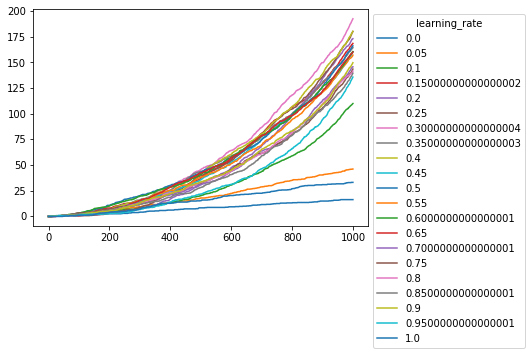

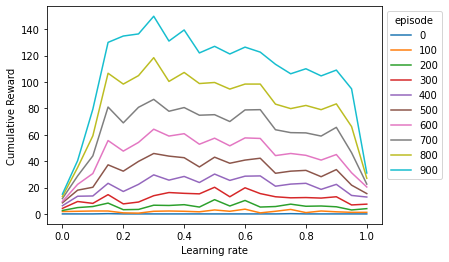

In [44]:
for i in range(number_of_tests):
    # plt.plot(x[i],y[i], label=learning_rate[i])
    plt.plot(z[i], label=learning_rate[i])

plt.legend(title="learning_rate", bbox_to_anchor=(1, 1))
plt.show()

z2 = np.asarray(z)
for i in range(0, len(z[0]), 100):
    plt.plot(learning_rate, z2[0:, i], label=i)
    
plt.xlabel("Learning rate")
plt.ylabel("Cumulative Reward")
plt.legend(title="episode", bbox_to_anchor=(1, 1))
plt.show()

# y = np.asarray(y)
# _,bins = y.shape
# for i in range(bins):
#     plt.plot(learning_rate, y[0:,i])

# plt.show()
# plt.plot(learning_rate,y[0:,-1])


FloatProgress(value=0.0, bar_style='info', description='Learning Rate:', max=1.0, style=ProgressStyle(bar_colo…

FloatProgress(value=0.0, bar_style='info', description='Iteration:', max=5.0, style=ProgressStyle(bar_color='#…

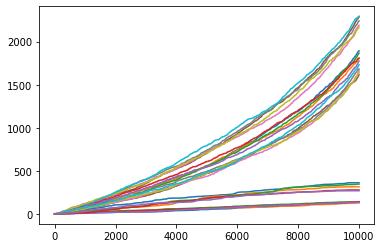

In [83]:
env = gym.make("FrozenLake-v1", is_slippery=True, map_name="4x4")
# env = CustomFrozenLakeEnv(is_slippery=False, map_name="4x4")

num_episodes = 10000


number_of_tests = 5
iterations_per_test = 5
learning_rates = np.linspace(0, 1, num=number_of_tests)

average_rewards = []
std = []

learning_progress_bar = widgets.FloatProgress(
    value=0,
    min=0,
    max=1,
    description='Learning Rate:',
    bar_style='info',
    style={'bar_color': '#ffff00'},
    orientation='horizontal'
)
iteration_progress_bar = widgets.FloatProgress(
    value=0,
    min=0,
    max=iterations_per_test,
    description='Iteration:',
    bar_style='info',
    style={'bar_color': '#ffff00'},
    orientation='horizontal'
)
display(learning_progress_bar)
display(iteration_progress_bar)

for learning_rate in learning_rates:
    learning_progress_bar.value = learning_rate

    learning_rate_average = []

    for j in range(iterations_per_test):
        iteration_progress_bar.value = j

        rewards_all_episodes = trainModel(env=env, num_episodes=num_episodes, learning_rate=learning_rate,
                                          discount_rate=0.9, max_exploration_rate=0.25, min_exploration_rate=0,
                                          exploration_decay_factor=10, linear_exploration=True, accuracy=20)
        cumulative_rewards = np.cumsum(rewards_all_episodes)
        plt.plot(cumulative_rewards, label=j)
        learning_rate_average.append(len(rewards_all_episodes))

    average_rewards.append(np.mean(learning_rate_average, 0))
    std.append(np.std(learning_rate_average))
    # plt.title("Learning Rate: {0}".format(learning_rate))
    # plt.xlabel("Episode")
    # plt.ylabel("Cumulative Score")
    # # plt.show()
    # plt.hist(learning_rate_average*10)
    # plt.show()


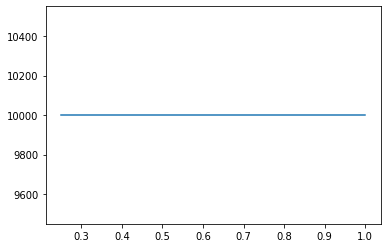

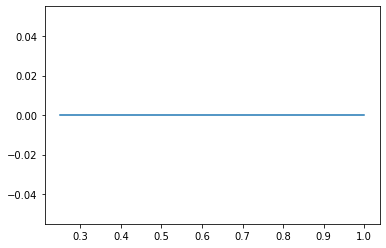

In [84]:
plt.plot(learning_rates[1:],average_rewards[1:])
plt.show()
plt.plot(learning_rates[1:],std[1:])

In [36]:
# random_map = generate_random_map(size=4, p=0.8)
# env = gym.make("FrozenLake-v0", desc=random_map)
env = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4")
for episode in range(1):
    state = env.reset()
    done = False
    print("*****EPISODE ", episode+1, "*****\n\n\n\n")
    time.sleep(1)

    for step in range(max_steps_per_episode):        
        clear_output(wait=True)
        env.render()
        time.sleep(0.3)
        
        action = np.argmax(q_table[state,:])        
        new_state, reward, done, info = env.step(action)
        
        if done:
            clear_output(wait=True)
            env.render()
            if reward == 1:
                print("****You reached the goal!****")
                time.sleep(3)
            else:
                print("****You fell through a hole!****")
                time.sleep(3)
            clear_output(wait=True)
            break
            
        state = new_state
        
env.close()

****You reached the goal!****


: 